This notebook is a **step-by-step PyTorch tutorial** that teaches how to train and evaluate a simple neural network on the MNIST dataset of handwritten digits. It is designed for **undergraduates with no prior experience in machine learning**.


Here’s the big picture intuition:
- **Neural networks learn patterns in data.** In this case, the network learns to recognize handwritten digits (0–9).
- We break the process into clear steps:
1. **Prepare the data** – Load images of digits and their labels (the correct answers).
2. **Build the model** – Define a simple neural network with layers of mathematical functions.
3. **Train the model** – Show the network many examples so it learns from its mistakes using a process called *gradient descent*.
4. **Evaluate the model** – Test the trained model on new, unseen images to check how well it performs.
- The **training loop** is where learning happens: the model makes predictions, we measure how wrong it is (loss), and then adjust the model’s parameters to improve.
- The **evaluation phase** checks accuracy, ensuring the model generalizes to data it hasn’t seen before.


By the end of this notebook, you’ll understand the essential workflow of machine learning: **data → model → training → evaluation**.

Step 1: Import Libraries

In [1]:
# We need to import PyTorch libraries to handle tensors, models, and optimization,
# and torchvision to load the MNIST dataset and perform transformations.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm # Import tqdm for progress bars

Step 2: Set device

In [2]:
# Check if a GPU is available. If yes, we will use it for faster computation, otherwise CPU will be used.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Step 3: Define transform

In [3]:
# MNIST images are 28x28 pixels in grayscale. We convert them to PyTorch tensors so the model can process them.
transform = transforms.ToTensor()

Step 4: Load MNIST dataset

* 'root' is the folder where the MNIST data is stored.
* 'train=True' loads the training data; 'train=False' loads the test data.
* 'download=False' because we already have the data.

In [4]:
mnist_root = "mnist_data" # change if your folder is elsewhere

train_dataset = datasets.MNIST(root=mnist_root, train=True, transform=transform, download=False)
test_dataset = datasets.MNIST(root=mnist_root, train=False, transform=transform, download=False)

# DataLoader wraps the dataset and allows us to iterate in batches
# 'batch_size' specifies how many images are processed at once
# 'shuffle=True' randomizes the order of images during training
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 60000
Number of test samples: 10000


Step 5: Define a simple neural network

In [5]:
# A neural network is a function that maps input images to output labels (digits 0-9)
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Flatten layer converts 28x28 image into a single 784-dimensional vector
        self.flatten = nn.Flatten()
        # Fully connected layer from 784 inputs to 128 neurons
        self.fc1 = nn.Linear(28*28, 128)
        # ReLU is an activation function introducing non-linearity
        self.relu = nn.ReLU()
        # Output layer with 10 neurons for 10 digit classes
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        # Define how data flows through the network
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = SimpleNN().to(device) # Move the model to GPU if available

Step 6: Define loss and optimizer

* Loss measures how far the model's predictions are from the correct answers
* CrossEntropyLoss is suitable for multi-class classification
* Adam optimizer adjusts the model's weights based on the gradients to reduce loss

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Step 7: Training loop

In [7]:
# We train the model for several epochs (iterations over the entire training set)
num_epochs = 5
for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    running_loss = 0.0
    # Wrap the DataLoader with tqdm to display a progress bar
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Move data to device (CPU or GPU)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass: pass images through the network
        outputs = model(images)
        # Compute the loss (how far predictions are from actual labels)
        loss = criterion(outputs, labels)
        
        # Backward pass: compute gradients of loss w.r.t model parameters
        optimizer.zero_grad() # Clear previous gradients to prevent accumulation
        loss.backward() # Compute new gradients
        optimizer.step() # Update model parameters using gradients
        
        # Add the batch loss to the running total
        running_loss += loss.item()
    
    # Compute and print average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

Epoch 1/5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:02<00:00, 464.28it/s]


Epoch [1/5], Average Loss: 0.3422


Epoch 2/5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:01<00:00, 504.79it/s]


Epoch [2/5], Average Loss: 0.1563


Epoch 3/5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:01<00:00, 519.01it/s]


Epoch [3/5], Average Loss: 0.1082


Epoch 4/5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:01<00:00, 497.44it/s]


Epoch [4/5], Average Loss: 0.0826


Epoch 5/5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:01<00:00, 505.42it/s]

Epoch [5/5], Average Loss: 0.0645


Step 8: Evaluation

In [8]:
# Before evaluating, we set the model to evaluation mode. This disables certain layers like dropout
# and batch normalization which behave differently during training.
model.eval()

# Initialize counters to track correct predictions and total number of samples
correct = 0
total = 0

# Wrap evaluation in torch.no_grad() context to avoid computing gradients, which saves memory and computation
with torch.no_grad():
    # Loop over test dataset in batches
    for images, labels in test_loader:
        # Move test data to the same device as the model
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass: compute the model outputs (predictions)
        outputs = model(images)
        
        # Get the predicted class for each image by finding the index with the maximum score
        _, predicted = torch.max(outputs.data, 1)
        
        # Update the total number of samples seen so far
        total += labels.size(0)
        
        # Count how many predictions matched the true labels
        correct += (predicted == labels).sum().item()

# Compute overall accuracy on the test set and print it
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 97.55%


Step 9: Visualizing samples

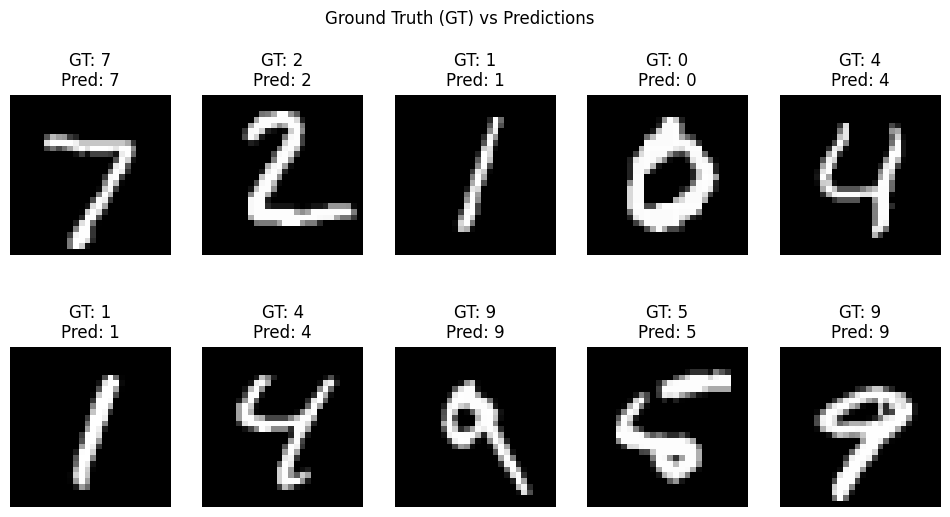

In [9]:
# Let's visualize some raw test images along with their ground truth and model predictions.
import matplotlib.pyplot as plt

# Get a small batch of test images
examples = iter(test_loader)
images, labels = next(examples)

# Move to device
images, labels = images.to(device), labels.to(device)

# Get model predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Plot the first 10 images with labels and predictions
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i].cpu().squeeze(), cmap="gray")  # Convert back to CPU for plotting
    plt.title(f"GT: {labels[i].item()}\nPred: {predicted[i].item()}")
    plt.axis("off")
plt.suptitle("Ground Truth (GT) vs Predictions")
plt.show()
